# Regression example using TabSRALinear: *Synthetic* 2 dataset


   $$y  = x_1^2{1}_{x_1\le 0}$$




## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
sys.path.append('../')
from SRAModels import TabSRALinear,LR
from utils import TrainRegressionModel,reset_seed_,Predict, load, save,LinearScaling


## Data

In [6]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
x3 = np.random.normal(0,1,3*10000)
x4 = np.random.normal(0,1,3*10000)
x5 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)  ),axis=1)

In [7]:
odd = (x1**2)*(x1<0)
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,odd,stratify =y , random_state=42)
n_features, n_classes = 5,1
len(Y_train_),len(Y_test_)

(22500, 7500)

In [8]:
feature_names = ['x1','x2','x3','x4','x5']
df_test = pd.DataFrame(X_test_,columns=feature_names)
df_test['y'] = Y_test_
df_test.head()

,x1,x2,x3,x4,x5,y
0,1.511155,-0.955850,-1.886978,0.299307,-0.130079,0.000000
1,-1.456938,-0.029552,-1.446098,0.644822,-0.729013,2.122667
2,-0.495999,0.133913,-0.695774,-0.171824,-0.371713,0.246015
3,-0.682022,0.957036,-0.217657,-0.030306,1.037440,0.465154
4,0.018017,-1.448417,-0.264760,0.466237,-1.770392,0.000000


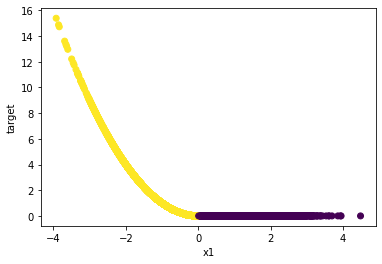

In [9]:
plt.scatter(x1, odd, c = y) #color[y]
plt.xlabel('x1')
plt.ylabel('target')
plt.show()

## Model: LR (Linear Regression)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_))
val_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_))

In [12]:
## function to build the model
def buildLR(static_params):
    Model = LR(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   bias = static_params['bias'],
                   for_classif=False
                  )
    return Model

In [13]:
static_params_LR = {'dim_input':n_features, 'dim_output':n_classes, 'bias':True}

In [14]:
%%time
reset_seed_(45)
SimpleLR = buildLR(static_params_LR)
save_model_dir= f'LR_Synthetic2'
SimpleLR = TrainRegressionModel(SimpleLR, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= 150,
                   batch_size = 256,
                   lr = 0.5*1e-2,
                   eval_every = 5,
                   weight_decay = 0.0,
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 0.7905448079109192
epoch = 5--rmse perf = 0.7613922357559204
epoch = 10--rmse perf = 0.7615777850151062
epoch = 15--rmse perf = 0.7608364820480347
epoch = 20--rmse perf = 0.7608946561813354
epoch = 25--rmse perf = 0.7611759901046753
epoch = 30--rmse perf = 0.761989951133728
epoch = 35--rmse perf = 0.7614490389823914
epoch = 40--rmse perf = 0.7614206671714783
epoch = 45--rmse perf = 0.7610563039779663
epoch = 50--rmse perf = 0.7607844471931458
epoch = 55--rmse perf = 0.7614076137542725
epoch = 60--rmse perf = 0.7618029713630676
epoch = 65--rmse perf = 0.7617277503013611
epoch = 70--rmse perf = 0.7611564993858337
epoch = 75--rmse perf = 0.7610608339309692
epoch = 80--rmse perf = 0.761361837387085
epoch = 85--rmse perf = 0.761650800704956
epoch = 90--rmse perf = 0.761552095413208
epoch = 95--rmse perf = 0.7611547708511353
epoch = 100--rmse perf = 0.7632535099983215
epoch = 105--rmse perf = 0.7610113620758057
epoch = 110--rmse perf = 0.7615567445755005
epoch = 115--r

In [15]:
pred_tab_lr = Predict(SimpleLR,val_set[:][0],device=device)
rmse = np.sqrt(mean_squared_error(Y_test_, pred_tab_lr))
r2 = r2_score(Y_test_, pred_tab_lr) 
print(f"--RMSE perf = {rmse} -- r2 perf = {r2}")

--RMSE perf = 0.7605895654807479 -- r2 perf = 0.5038074852086862


## Model: TabSRALinear 

In [16]:
## function to build the model
def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5),
                   for_classif=False
                  )
    return Model

In [17]:
## The hyperparameters are already optimized (using optuna) 
config_opt = {'lr': 1e-2, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 150, 'weight_decay': 1e-6, 'batch_size': 768}
static_params = {'dim_input':n_features, 'dim_output':n_classes,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}


In [18]:
%%time
reset_seed_(42)
Model = buildTabSRA(config_opt,static_params)
save_model_dir= f'TabSRALinear_Synthetic2'
Model = TrainRegressionModel(Model, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= config_opt['epochs'],
                   batch_size = config_opt['batch_size'],
                   lr = config_opt['lr'],
                   eval_every = 5,
                   weight_decay = config_opt['weight_decay'],
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 0.879551112651825
epoch = 5--rmse perf = 0.2770652174949646
epoch = 10--rmse perf = 0.17170201241970062
epoch = 15--rmse perf = 0.12487591058015823
epoch = 20--rmse perf = 0.09815322607755661
epoch = 25--rmse perf = 0.08277104794979095
epoch = 30--rmse perf = 0.0708114355802536
epoch = 35--rmse perf = 0.06270794570446014
epoch = 40--rmse perf = 0.05509037524461746
epoch = 45--rmse perf = 0.046343158930540085
epoch = 50--rmse perf = 0.044442445039749146
epoch = 55--rmse perf = 0.03780115768313408
epoch = 60--rmse perf = 0.03490132838487625
epoch = 65--rmse perf = 0.032956115901470184
epoch = 70--rmse perf = 0.03010094165802002
epoch = 75--rmse perf = 0.027525506913661957
epoch = 80--rmse perf = 0.029259437695145607
epoch = 85--rmse perf = 0.026883944869041443
epoch = 90--rmse perf = 0.03328671306371689
epoch = 95--rmse perf = 0.023508822545409203
epoch = 100--rmse perf = 0.025713074952363968
epoch = 105--rmse perf = 0.02486792393028736
epoch = 110--rmse perf = 0.0

In [19]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
att,pred_tabsra = Predict(Model,val_set[:][0],device=device)

rmse_tabsra = np.sqrt(mean_squared_error(Y_test_, pred_tabsra))
r2_tabsra = r2_score(Y_test_, pred_tabsra) 
print(f"--RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")

--RMSE perf = 0.01962256630061539 -- r2 perf = 0.9996697361093607


In [20]:
Model.classifier.weight

Parameter containing:
tensor([[-3.4950, -1.6255,  1.5929, -1.6117,  1.7705]], device='cuda:0',
       requires_grad=True)

## Model: XGBoost 

In [21]:
from xgboost import XGBRegressor


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [22]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBRegressor(**config_opt)
    return model_xgb

In [23]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.03425616464106714,
              'max_depth': 5,
              'colsample_bytree': 0.8,
              'subsample': 0.7,
              'n_estimators': 910,
              'min_child_weight':56

              }
static_params_xgb = {
                 'random_state':45,
                 'n_jobs': -1,
}


In [24]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['rmse'], eval_set=eval_set, verbose=1)

[0]	validation_0-rmse:1.04373
[1]	validation_0-rmse:1.00851
[2]	validation_0-rmse:0.97449
[3]	validation_0-rmse:0.94185
[4]	validation_0-rmse:0.91031
[5]	validation_0-rmse:0.87974
[6]	validation_0-rmse:0.87973
[7]	validation_0-rmse:0.85025
[8]	validation_0-rmse:0.82183
[9]	validation_0-rmse:0.82183
[10]	validation_0-rmse:0.79418
[11]	validation_0-rmse:0.76758
[12]	validation_0-rmse:0.74202
[13]	validation_0-rmse:0.71717
[14]	validation_0-rmse:0.69329
[15]	validation_0-rmse:0.67029
[16]	validation_0-rmse:0.64809
[17]	validation_0-rmse:0.62667
[18]	validation_0-rmse:0.60600
[19]	validation_0-rmse:0.60600
[20]	validation_0-rmse:0.58605
[21]	validation_0-rmse:0.58606
[22]	validation_0-rmse:0.56687
[23]	validation_0-rmse:0.54823
[24]	validation_0-rmse:0.53029
[25]	validation_0-rmse:0.51279
[26]	validation_0-rmse:0.49586
[27]	validation_0-rmse:0.47978
[28]	validation_0-rmse:0.46403
[29]	validation_0-rmse:0.46404
[30]	validation_0-rmse:0.46405
[31]	validation_0-rmse:0.46405
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.03425616464106714, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.034256164,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=910, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict(X_test_)
best_rmse_xgb = np.sqrt(mean_squared_error(Y_test_, pred_xgboost) )
best_r2_xgb = r2_score(Y_test_, pred_xgboost) 
print(f"--RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")

--RMSE perf = 0.08999699917470588 -- r2 perf = 0.9930528681744824


## Interpretability: using feature attribution on the test data

- For Linear Regression, the effect is given by $\beta\odot x$ where $\beta$ is the regression coefficients.
- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the SRA attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [26]:
%%time
attributions_lr = pd.DataFrame(SimpleLR.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_lr.columns = feature_names
attributions_lr['pred'] = pred_tab_lr
attributions_lr['label'] = val_set[:][1].numpy()

CPU times: user 13.2 ms, sys: 45.1 ms, total: 58.3 ms
Wall time: 3.97 ms


In [27]:
%%time
attributions_tabsra = pd.DataFrame(att*Model.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_tabsra.columns = feature_names
attributions_tabsra['pred'] = pred_tabsra
attributions_tabsra['label'] = val_set[:][1].numpy()

CPU times: user 0 ns, sys: 22.3 ms, total: 22.3 ms
Wall time: 1.69 ms


In [28]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred'] = pred_xgboost
attributions_xgb['label'] = val_set[:][1].numpy()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 17.7 s, sys: 1.73 s, total: 19.5 s
Wall time: 1.65 s


LR --RMSE perf = 0.7605895654807479 -- r2 perf = 0.5038074852086862


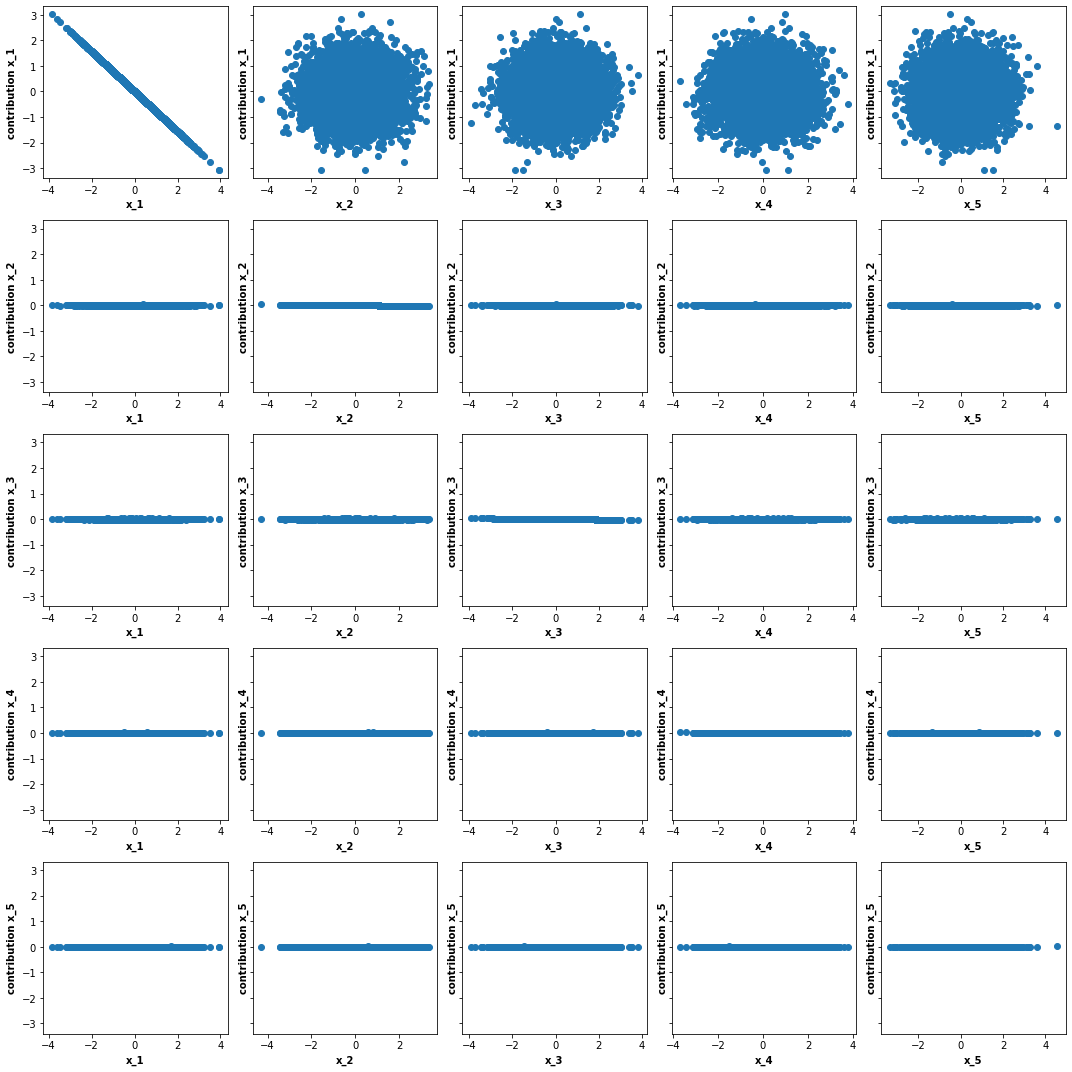

In [29]:
print(f"LR --RMSE perf = {rmse} -- r2 perf = {r2}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_lr[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

TabSRALinear --RMSE perf = 0.01962256630061539 -- r2 perf = 0.9996697361093607


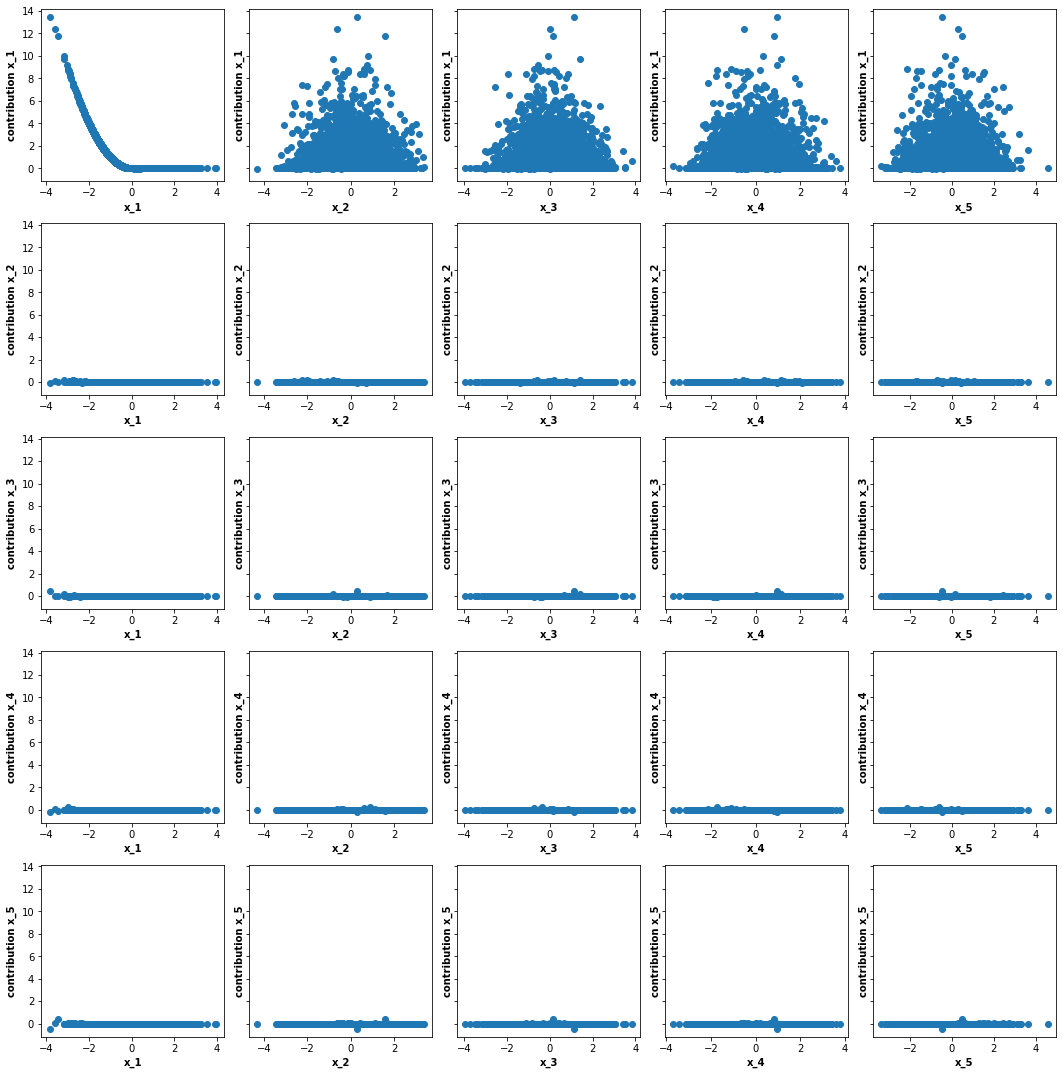

In [30]:
print(f"TabSRALinear --RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_tabsra[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

XGBoost --RMSE perf = 0.08999699917470588 -- r2 perf = 0.9930528681744824


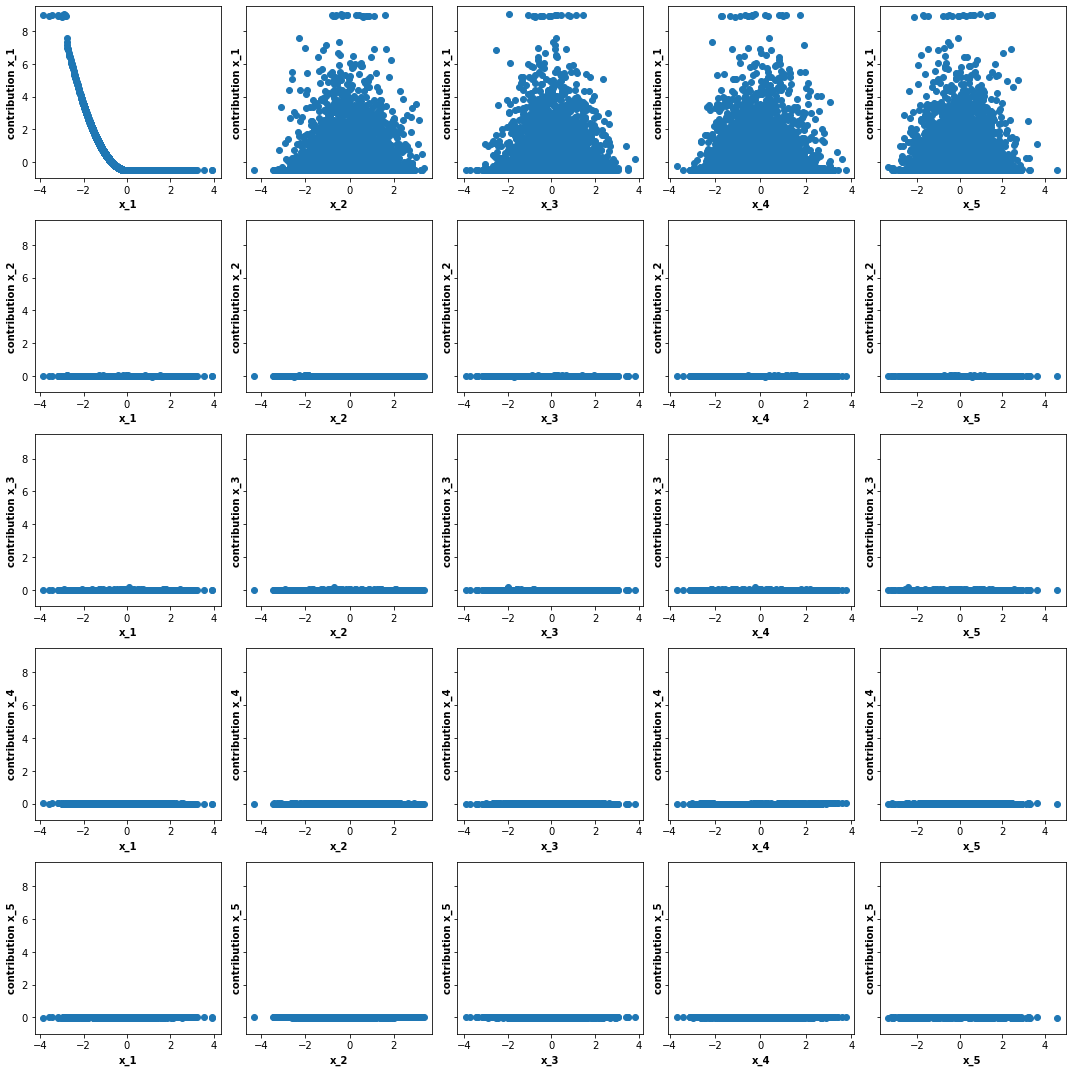

In [31]:
print(f"XGBoost --RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_xgb[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

## Identification of important features

We consider in the test set observations where $x_1 \le 0$  hence only $x_1$ should
have nonzero importance

In [32]:
### Add x5
attributions_lr['x1_raw'] = df_test["x1"]
attributions_tabsra['x1_raw'] = df_test["x1"]
attributions_xgb['x1_raw'] = df_test["x1"]

In [33]:
attributions_lr_tmp = attributions_lr[attributions_lr.x1_raw<0]
attributions_tabsra_tmp = attributions_tabsra[attributions_tabsra.x1_raw<0]
attributions_xgb_tmp = attributions_xgb[attributions_xgb.x1_raw<0]

In [34]:
attributions_tabsra_tmp.head()

,x1,x2,x3,x4,x5,pred,label,x1_raw
1,2.114470,0.000248,-1.849172e-06,-1.216914e-05,-2.781658e-05,2.117475,2.122667,-1.456938
2,0.241988,-0.000063,-1.551178e-06,1.660322e-07,-6.425068e-06,0.244716,0.246015,-0.495999
3,0.468904,-0.001127,-1.863675e-06,4.154496e-08,1.299657e-04,0.470704,0.465154,-0.682022
6,2.850250,0.016016,-8.028050e-06,-1.052741e-05,1.019692e-03,2.870067,2.877489,-1.696316
8,0.015381,0.000003,-7.486400e-08,3.744449e-07,-7.102748e-07,0.018183,0.011923,-0.109193


In [35]:
precision_lr = np.argsort(attributions_lr_tmp[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_lr.mean()

0.9911835426128773

In [36]:
precision_tabsra = np.argsort(attributions_tabsra_tmp[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_tabsra.mean()

0.9997328346246327

In [37]:
precision_xgb= np.argsort(attributions_xgb_tmp[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_xgb.mean()

0.9970611808709591